# *Enterococcus* analysis

In [ ]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [ ]:
import sys
import math
from pathlib import Path
from collections import defaultdict

import numpy
import pandas
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
seaborn.set_style("whitegrid")

mpl.rcParams['figure.dpi'] = 72
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['grid.color'] = '#dddddd'

In [ ]:
counter = defaultdict(int)
with open("/gsap/archive-bacterial/Projects/StrainGE/refseq/enterococcus/strainge_db/to_keep.txt") as f:
    for line in f:
        species = Path(line.strip()).stem.split('_')[1]
        counter[species] += 1
        
print(sum(v for k, v in counter.items() if k not in {'faecalis', 'faecium'}))
counter

In [ ]:
from pandas.api.types import CategoricalDtype

BASE_PATH = Path("/gsap/archive-bacterial/Projects/StrainGE/strainge-benchmarks/birth_microbiome")

accession_meta = pandas.read_csv(BASE_PATH / "data/samples_ena.txt", sep='\t', index_col='secondary_sample_accession')
sample_meta = pandas.read_csv(BASE_PATH / "data/samples_meta.txt", sep='\t', index_col='Accession')

def timepoint_sort(e):
    if e.isnumeric():
        return int(e)
    elif e == 'Infancy':
        return sys.maxsize
    else:
        return -1
        
timepoints = list(sorted(sample_meta['Time_point'].unique(), key=timepoint_sort))
timepoint_dtype = CategoricalDtype(timepoints, ordered=True)

sample_meta['Time_point'] = sample_meta['Time_point'].astype(timepoint_dtype)

accession_meta = accession_meta.join(sample_meta)
run_meta = accession_meta.reset_index().set_index('run_accession')

run_meta

In [ ]:
sample_meta['Time_point']

In [ ]:
mlst = pandas.read_csv("/gsap/archive-bacterial/Projects/StrainGE/refseq/enterococcus/strainge_db/mlst.tsv", sep='\t', 
                       usecols=[0, 1, 2], names=['filename', 'scheme', 'st'], na_values=["-"])
mlst['ref'] = mlst['filename'].str.rstrip(".fa.gz")
mlst = mlst.dropna().set_index(['ref'])
mlst['st'] = mlst['st'].astype(int)

display(mlst)


## Helper functions to load StrainGST data

In [ ]:
from strainge.io.utils import parse_straingst


def nice_ref_name(name):
    parts = name.split("_")
    
    first_letter = parts[0][0]
    strain = " ".join(parts[2:])
    return f"{first_letter}. {parts[1]} {strain}"

def straingst_to_df(paths):
    sample_data = []
    straingst_dfs = []
    for path in paths:
        with path.open() as f:
            straingst_iter = iter(parse_straingst(f, return_sample_stats=True))
            try:
                sample_stats = next(straingst_iter)
                sample_data.append(sample_stats)
            except RuntimeError:
                print("Could not load", path, file=sys.stderr)
                continue

            data = []
            for r in straingst_iter:
                data.append(r)
            straingst_dfs.append(pandas.DataFrame(data))

    samples_df = pandas.DataFrame(sample_data).set_index('sample')
    samples_df = samples_df.sort_values('sample')
    
    straingst_results = pandas.concat(straingst_dfs, keys=[s['sample'] for s in sample_data], names=['sample']).reset_index(level=1, drop=True)
    straingst_results = straingst_results.apply(pandas.to_numeric, errors='ignore')
    straingst_results['nice_name'] = straingst_results['strain'].map(nice_ref_name)
    return samples_df, straingst_results.join(samples_df, how='left').set_index('strain', append=True)

In [ ]:
STRAINGST_PATH = BASE_PATH / "straingst"
samples_df, straingst_df = straingst_to_df(STRAINGST_PATH.glob("metagenomes/*.tsv"))

straingst_df = straingst_df.join(run_meta, on='sample', how='left').reset_index().set_index(['Individual', 'Time_point', 'i', 'strain']).sort_index().reset_index(level=2)
straingst_df['st'] = straingst_df.index.map(lambda ix: mlst.loc[ix[2], 'st'] if ix[2] in mlst.index else numpy.nan)

without_infancy_df = straingst_df.loc[straingst_df.index.get_level_values(1) != 'Infancy'].copy()
straingst_df

In [ ]:
straingst_df.reset_index()['Time_point'].value_counts()

In [184]:
species = straingst_df.index.map(lambda ix: ix[2].split('_')[1])
print(len(species))
print(108+79+58+12+10+5+1)
display(species.value_counts())
display(species.value_counts(normalize=True) * 100)

2024
273


faecalis         1306
faecium           171
avium             140
casseliflavus     134
sp.               108
durans             79
gallinarum         58
gilvus             12
hirae              10
lactis              5
cecorum             1
dtype: int64

faecalis         64.525692
faecium           8.448617
avium             6.916996
casseliflavus     6.620553
sp.               5.335968
durans            3.903162
gallinarum        2.865613
gilvus            0.592885
hirae             0.494071
lactis            0.247036
cecorum           0.049407
dtype: float64

In [163]:
with pandas.option_context('display.max_rows', None):
    st_pct = straingst_df['st'].value_counts(normalize=True) * 100
    display(st_pct)
    
    print(st_pct.loc[[40.0, 711.0, 16.0, 30.0, 191.0]].sum())

776.0     14.205738
40.0      10.006998
711.0      9.797061
16.0       9.097271
30.0       7.207838
25.0       6.787964
191.0      5.738279
314.0      4.828551
22.0       4.688593
19.0       3.358992
248.0      3.009097
160.0      2.029391
591.0      1.609517
178.0      1.469559
266.0      1.119664
55.0       0.979706
1.0        0.909727
2.0        0.839748
1034.0     0.839748
8.0        0.769769
296.0      0.769769
28.0       0.699790
4.0        0.699790
812.0      0.629811
691.0      0.559832
18.0       0.489853
21.0       0.419874
745.0      0.419874
710.0      0.349895
6.0        0.349895
74.0       0.349895
648.0      0.349895
361.0      0.349895
80.0       0.349895
323.0      0.349895
729.0      0.279916
66.0       0.279916
103.0      0.279916
17.0       0.209937
489.0      0.209937
482.0      0.209937
141.0      0.209937
108.0      0.139958
9.0        0.139958
54.0       0.139958
172.0      0.139958
203.0      0.139958
1118.0     0.139958
695.0      0.069979
76.0       0.069979


41.84744576627011


In [167]:
len(straingst_df.index.unique(level=2))

107

In [293]:
straingst_first = straingst_df[straingst_df['i'] == 0].copy()
species = straingst_first.index.map(lambda ix: ix[2].split('_')[1])
print(len(species))
print(108+79+58+12+10+5+1)
display(species.value_counts())
display(species.value_counts(normalize=True) * 100)

1069
273


faecalis         776
faecium           81
avium             66
sp.               51
durans            39
casseliflavus     32
gallinarum        16
hirae              6
lactis             2
dtype: int64

faecalis         72.591207
faecium           7.577175
avium             6.173994
sp.               4.770814
durans            3.648269
casseliflavus     2.993452
gallinarum        1.496726
hirae             0.561272
lactis            0.187091
dtype: float64

## Mine StrainGST results for a subset of individuals

In [258]:
individuals_2tp = set()
individuals_with_mother = set()
individuals_with_shared_strain_mother = defaultdict(set)

for individual in straingst_df.index.unique(level=0):
    samples_with_entero = list(straingst_df.loc[individual, 'sample'].unique())
    if len(samples_with_entero) > 1:
        individuals_2tp.add(individual)
        
    if (individual, "Mother") in straingst_df.index:
        individuals_with_mother.add(individual)
        
        individual_df = straingst_df.loc[individual, :].copy()
        mother_strains = set(individual_df.loc["Mother"].index)
        other_strains = set(individual_df.loc[individual_df.index.get_level_values(0) != "Mother", :].index.get_level_values(1))
        shared_strains = mother_strains & other_strains
        
        if shared_strains:
            individuals_with_shared_strain_mother[individual].update(shared_strains)
    
individuals_of_interest = individuals_2tp & individuals_with_mother

In [259]:
individuals_with_shared_strain_mother

defaultdict(set,
            {'606141': {'Ente_faecalis_SGAir0397'},
             'A00576': {'Ente_faecium_NCTC7174'},
             'A02064': {'Ente_faecalis_L12'},
             'B00046': {'Ente_faecium_DMEA02'},
             'B00922': {'Ente_faecalis_LD33'},
             'B01471': {'Ente_faecalis_FDAARGOS_324', 'Ente_faecalis_L12'},
             'B02159': {'Ente_durans_KCTC_13289'},
             'C01443': {'Ente_faecalis_NCTC8732'},
             'C01485': {'Ente_faecalis_LD33'},
             'C01758': {'Ente_faecalis_Symbioflor_1'},
             'C01930': {'Ente_faecium_DMEA02'},
             'C02047': {'Ente_faecalis_KUB3006'},
             'C02056': {'Ente_faecalis_133170041-3'},
             'C02058': {'Ente_faecalis_NCTC8732'},
             'C02295': {'Ente_durans_KCTC_13289'},
             'C02756': {'Ente_faecium_3012STDY6244127'},
             'S7': {'Ente_durans_KCTC_13289'}})

In [206]:
interested_df = straingst_df.loc[list(individuals_of_interest), :].copy()

interested_df.groupby(['Individual']).first()['Delivery_mode'].value_counts()

Vaginal      23
Caesarean    23
Name: Delivery_mode, dtype: int64

In [207]:
with pandas.option_context('display.max_rows', None):
    display(interested_df.groupby('strain').agg({"sample": "nunique"}).sort_values('sample'))

,sample
strain,
Ente_faecalis_CVM_N48037F,1
Ente_faecium_BM4105-RF,1
Ente_faecium_CBA7134,1
Ente_faecalis_OG1RF,1
Ente_faecium_E1774,1
Ente_faecium_E9101,1
Ente_faecium_EFE10021,1
Ente_faecium_ISMMS_VRE_1,1
Ente_faecium_KUHS13,1


In [288]:
import random
import itertools
from collections import defaultdict

import altair as alt
from matplotlib.colors import rgb2hex

all_strains = list(sorted(straingst_df.index.unique(level=2)))
all_strains = list(map(nice_ref_name, all_strains))

strains_per_species = defaultdict(list)
for strain in all_strains:
    species = strain.split(' ')[1]
    strains_per_species[species].append(strain)
    
print(strains_per_species.keys())

colorblind_palette = seaborn.color_palette("colorblind")
species_to_hue = {
    "faecalis": 0,
    "faecium": 1,
    "durans": 2,
    "casseliflavus": 4,
    "avium": 5,
    "cecorum": 6,
    "gallinarum": 7,
    "sp.": 8,
    "hirae": 9,
    "lactis": 3,
    "gilvus": 9,
}

colormap_per_species = {
    species: seaborn.light_palette(colorblind_palette[species_to_hue[species]], n_colors=len(strains)+2, reverse=True, input='rgb')[:len(strains)]
    for i, (species, strains) in enumerate(strains_per_species.items())
}

strain_colors = [rgb2hex(c) for c in itertools.chain.from_iterable(colormap_per_species.values())]
strain_color_map = dict(zip(all_strains, strain_colors))
strain_color_scale = alt.Scale(domain=all_strains, range=strain_colors)

substraingst_df = straingst_df[straingst_df.index.get_level_values(1).isin({'Mother', '4', '7', '21'})].copy()
vaginal_subjects = random.sample(
    list(substraingst_df[substraingst_df['Delivery_mode'] == "Vaginal"].index.unique(level=0)),
    10
)
vaginal_df = substraingst_df.loc[vaginal_subjects, :].copy()
caesarean_subjects = random.sample(
    list(substraingst_df[substraingst_df['Delivery_mode'] == "Caesarean"].index.unique(level=0)),
    10
)
caesarean_df = substraingst_df.loc[caesarean_subjects, :].copy()

concat_df = pandas.concat([vaginal_df, caesarean_df])
max_ra = concat_df.groupby(level=[0, 1]).sum()['rapct'].max()
print(max_ra)
vaginal_strains = list(map(nice_ref_name, sorted(vaginal_df.index.unique(level=2))))
vaginal_colors = [strain_color_map[s] for s in vaginal_strains]
vaginal_color_scale = alt.Scale(domain=vaginal_strains, range=vaginal_colors)

caesarean_strains = list(map(nice_ref_name, sorted(caesarean_df.index.unique(level=2))))
caesarean_colors = [strain_color_map[s] for s in caesarean_strains]
caesarean_color_scale = alt.Scale(domain=caesarean_strains, range=caesarean_colors)

vaginal_chart = alt.Chart(vaginal_df.reset_index()).mark_bar(clip=True).encode(
    x=alt.X('Time_point:O', title="Time point", sort=timepoints, scale=alt.Scale(domain=['Mother', '4', '7', '21'])),
    y=alt.Y('sum(rapct):Q', title="Relative abundance [%]", scale=alt.Scale(domain=[0, max_ra+5])),
    color=alt.Color('nice_name:N', scale=vaginal_color_scale, title="Reference"),
    tooltip=['strain', 'sample']
).properties(
    title="StrainGST results for vaginal born children",
    width=100,
    height=100,
).facet(
    facet='Individual:N',
    columns=5
).resolve_scale(
    x='independent',
    y='shared'
)

display(vaginal_chart)

caesarean_chart = alt.Chart(caesarean_df.reset_index()).mark_bar(clip=True).encode(
    x=alt.X('Time_point:O', title="Time point", sort=timepoints, scale=alt.Scale(domain=['Mother', '4', '7', '21'])),
    y=alt.Y('sum(rapct):Q', title="Relative abundance [%]", scale=alt.Scale(domain=[0, max_ra+5])),
    color=alt.Color('nice_name:N', scale=caesarean_color_scale, title="Reference"),
    tooltip=['strain', 'sample']
).properties(
    title="StrainGST results for caesarean born children",
    width=100,
    height=100,
).facet(
    facet='Individual:N',
    columns=5
).resolve_scale(
    x='independent',
    y='shared'
)

display(caesarean_chart)

dict_keys(['avium', 'casseliflavus', 'cecorum', 'durans', 'faecalis', 'faecium', 'gallinarum', 'gilvus', 'hirae', 'lactis', 'sp.'])
81.808


alt.FacetChart(...)

alt.FacetChart(...)

## Load StrainGR summary data

In [ ]:
def load_straingr_summaries(straingst_df, paths):
    summary_dfs = []
    samples = []

    for f in paths:
        try:
            df = pandas.read_csv(f, sep='\t')
            df = df[df['ref'] != "TOTAL"].copy()
            summary_dfs.append(df)
            samples.append(f.stem)
        except pandas.errors.EmptyDataError:
            pass

    summaries = pandas.concat(summary_dfs, keys=samples, names=['sample']).reset_index(level=1, drop=True).set_index(['ref', 'name'], append=True)
    summaries['nonGapPct'] = 100 - ((summaries['gapLength'] / summaries['length']) * 100)
    summaries = summaries.join(run_meta, on='sample', how='left').reset_index().set_index(['Individual', 'Time_point', 'ref', 'name']).sort_index()
    
    def straingst_present(ix):
        individual, timepoint, ref, contig = ix
        return (individual, timepoint, ref) in straingst_df.index
    
    summaries['straingst_present'] = summaries.index.map(straingst_present)
    
    return summaries

In [230]:
STRAINGR_PATH = BASE_PATH / "straingr/"
summary_files = (p for p in STRAINGR_PATH.glob("**/*.tsv") if p.parts[-2] != "concat_refs")
summaries_df = load_straingr_summaries(straingst_df, summary_files)
summaries_pass_qc = summaries_df[summaries_df['straingst_present']].copy()

In [231]:
summaries_df

sample  \
Individual Time_point ref                        name                        
512120     4          Ente_faecalis_JY32         NZ_CP045045.1  ERR3404638   
                      Ente_faecalis_NCTC8732     NZ_LR594051.1  ERR3404638   
                      Ente_faecalis_SGAir0397    NZ_CP039434.1  ERR3404638   
           7          Ente_faecalis_JY32         NZ_CP045045.1  ERR3404639   
                      Ente_faecalis_NCTC8732     NZ_LR594051.1  ERR3404639   
...                                                                    ...   
S8         21         Ente_faecalis_133170041-3  NZ_CP046108.1  ERR3404692   
                      Ente_faecalis_FDAARGOS_324 NZ_CP028285.1  ERR3404692   
                      Ente_faecalis_JY32         NZ_CP045045.1  ERR3404692   
S9         4          Ente_faecalis_133170041-3  NZ_CP046108.1  ERR3404693   
                      Ente_faecalis_FDAARGOS_324 NZ_CP028285.1  ERR3404693   

                                                                 length  \
Individual Time_point ref                        name                     
512120     4          Ente_faecalis_JY32         NZ_CP045045.1  2933718   
                      Ente_faecalis_NCTC8732     NZ_LR594051.1  2864420   
                      Ente_faecalis_SGAir0397    NZ_CP039434.1  2696714   
           7          Ente_faecalis_JY32         NZ_CP045045.1  2933718   
                      Ente_faecalis_NCTC8732     NZ_LR594051.1  2864420   
...                                                                 ...   
S8         21         Ente_faecalis_133170041-3  NZ_CP046108.1  2910333   
                      Ente_faecalis_FDAARGOS_324 NZ_CP028285.1  2928142   
                      Ente_faecalis_JY32         NZ_CP045045.1  2933718   
S9         4          Ente_faecalis_133170041-3  NZ_CP046108.1  2910333   
                      Ente_faecalis_FDAARGOS_324 NZ_CP028285.1  2928142   

                                                                coverage  \
Individual Time_point ref                        name                      
512120     4          Ente_faecalis_JY32         NZ_CP045045.1    19.680   
                      Ente_faecalis_NCTC8732     NZ_LR594051.1    43.379   
                      Ente_faecalis_SGAir0397    NZ_CP039434.1    25.611   
           7          Ente_faecalis_JY32         NZ_CP045045.1     8.414   
                      Ente_faecalis_NCTC8732     NZ_LR594051.1    35.981   
...                                                                  ...   
S8         21         Ente_faecalis_133170041-3  NZ_CP046108.1     4.303   
                      Ente_faecalis_FDAARGOS_324 NZ_CP028285.1     3.576   
                      Ente_faecalis_JY32         NZ_CP045045.1     4.621   
S9         4          Ente_faecalis_133170041-3  NZ_CP046108.1     8.098   
                      Ente_faecalis_FDAARGOS_324 NZ_CP028285.1     8.289   

                                                                uReads  \
Individual Time_point ref                        name                    
512120     4          Ente_faecalis_JY32         NZ_CP045045.1  117893   
                      Ente_faecalis_NCTC8732     NZ_LR594051.1  624532   
                      Ente_faecalis_SGAir0397    NZ_CP039434.1  248188   
           7          Ente_faecalis_JY32         NZ_CP045045.1   31034   
                      Ente_faecalis_NCTC8732     NZ_LR594051.1  609425   
...                                                                ...   
S8         21         Ente_faecalis_133170041-3  NZ_CP046108.1   38588   
                      Ente_faecalis_FDAARGOS_324 NZ_CP028285.1   27741   
                      Ente_faecalis_JY32         NZ_CP045045.1   51012   
S9         4          Ente_faecalis_133170041-3  NZ_CP046108.1  115725   
                      Ente_faecalis_FDAARGOS_324 NZ_CP028285.1  121774   

                                                                abundance  \
Individual Time_point ref                       

## Comparison of all strains across all subjects

In [232]:
def straingst_present_func(straingst_df):
    def func(ix):
        i1, i2, s1, s2, ref = ix
        return (i1, s1, ref) in straingst_df.index and (i2, s2, ref) in straingst_df.index
    
    return func


def enough_cov_func(straingr_df):
    def func(ix):
        i1, i2, s1, s2, ref = ix
        return (i1, s1, ref) in straingr_df.index and (i2, s2, ref) in straingr_df.index
    
    return func


In [233]:
COMPARE_COMPLETE_TSV = BASE_PATH / "strainge_compare/compare_complete.tsv"
if COMPARE_COMPLETE_TSV.is_file():
    compare_complete_df = pandas.read_csv(COMPARE_COMPLETE_TSV, sep='\t', index_col=[0, 1, 2, 3, 4])
else:
    compare_data = []
    COMPARE_SUMMARIES = BASE_PATH / "strainge_compare/"
    for f in COMPARE_SUMMARIES.glob("**/*.summary.tsv"):
        df = pandas.read_csv(f, sep='\t', index_col=[0, 1, 2])
        compare_data.append(df)

    compare_complete_df = pandas.concat(compare_data)
    compare_complete_df = compare_complete_df[~compare_complete_df.index.duplicated(keep='first')]
    compare_complete_df['subject1'] = compare_complete_df.index.map(lambda ix: run_meta.loc[ix[0], 'Individual'])
    compare_complete_df['subject2'] = compare_complete_df.index.map(lambda ix: run_meta.loc[ix[1], 'Individual'])
    compare_complete_df['same_subject'] = compare_complete_df['subject1'] == compare_complete_df['subject2']
    compare_complete_df['tp1'] = compare_complete_df.index.map(lambda ix: run_meta.loc[ix[0], 'Time_point'])
    compare_complete_df['tp2'] = compare_complete_df.index.map(lambda ix: run_meta.loc[ix[1], 'Time_point'])

    compare_complete_df = compare_complete_df.reset_index().set_index(['subject1', 'subject2', 'tp1', 'tp2', 'ref'])
    compare_complete_df['straingst_present'] = compare_complete_df.index.map(straingst_present_func(straingst_df))
    compare_complete_df['enough_cov'] = compare_complete_df.index.map(enough_cov_func(summaries_pass_qc))
    compare_complete_df.to_csv(COMPARE_COMPLETE_TSV, sep='\t')
    
compare_complete_df['nice_name'] = compare_complete_df.index.map(lambda ix: nice_ref_name(ix[4]))
compare_complete_df['hospital1'] = compare_complete_df['sample1'].map(lambda sample: run_meta.loc[sample, 'Hospital'])
compare_complete_df['hospital2'] = compare_complete_df['sample2'].map(lambda sample: run_meta.loc[sample, 'Hospital'])
compare_complete_df['same_hospital'] = compare_complete_df['hospital1'] == compare_complete_df['hospital2']
compare_complete_df['species'] = compare_complete_df.index.map(lambda ix: ix[4].split('_')[1])
compare_complete_df['st'] = compare_complete_df.index.map(lambda ix: mlst.loc[ix[4], 'st'] if ix[4] in mlst.index else numpy.nan)

compare_complete_df_pass_qc = compare_complete_df[compare_complete_df['straingst_present'] & compare_complete_df['enough_cov'] & (compare_complete_df['commonPct'] > 0.5)]
same_subject_compare = compare_complete_df_pass_qc[compare_complete_df_pass_qc['same_subject']].copy()
between_subject_compare = compare_complete_df_pass_qc[~compare_complete_df_pass_qc['same_subject']].copy()

In [234]:
compare_complete_df_pass_qc

sample1  \
subject1 subject2 tp1     tp2     ref                                        
A01739   B01775   Infancy 21      Ente_gallinarum_FDAARGOS_163  ERR3405861   
B02316   C01696   Infancy Infancy Ente_faecium_E1334            ERR3406205   
                                  Ente_gallinarum_FDAARGOS_163  ERR3406205   
B01773   B01848   Infancy Infancy Ente_gallinarum_FDAARGOS_163  ERR3406079   
         B01775   Infancy 21      Ente_gallinarum_FDAARGOS_163  ERR3406079   
...                                                                    ...   
A01763   A01921   7       7       Ente_faecalis_FDAARGOS_324    ERR3405791   
A02064   C01758   21      21      Ente_faecalis_FDAARGOS_324    ERR3405458   
604136   B02159   7       7       Ente_faecalis_FDAARGOS_324    ERR3404676   
606141   B00243   7       4       Ente_faecalis_FDAARGOS_324    ERR3404634   
B02165   C01832   21      7       Ente_faecalis_FDAARGOS_324    ERR3405827   

                                                                   sample2  \
subject1 subject2 tp1     tp2     ref                                        
A01739   B01775   Infancy 21      Ente_gallinarum_FDAARGOS_163  ERR3405575   
B02316   C01696   Infancy Infancy Ente_faecium_E1334            ERR3406220   
                                  Ente_gallinarum_FDAARGOS_163  ERR3406220   
B01773   B01848   Infancy Infancy Ente_gallinarum_FDAARGOS_163  ERR3406245   
         B01775   Infancy 21      Ente_gallinarum_FDAARGOS_163  ERR3405575   
...                                                                    ...   
A01763   A01921   7       7       Ente_faecalis_FDAARGOS_324    ERR3405372   
A02064   C01758   21      21      Ente_faecalis_FDAARGOS_324    ERR3405526   
604136   B02159   7       7       Ente_faecalis_FDAARGOS_324    ERR3405830   
606141   B00243   7       4       Ente_faecalis_FDAARGOS_324    ERR3404925   
B02165   C01832   21      7       Ente_faecalis_FDAARGOS_324    ERR3405396   

                                                                     scaffold  \
subject1 subject2 tp1     tp2     ref                                           
A01739   B01775   Infancy 21      Ente_gallinarum_FDAARGOS_163  NZ_CP014067.2   
B02316   C01696   Infancy Infancy Ente_faecium_E1334            NZ_LR134095.1   
                                  Ente_gallinarum_FDAARGOS_163  NZ_CP014067.2   
B01773   B01848   Infancy Infancy Ente_gallinarum_FDAARGOS_163  NZ_CP014067.2   
         B01775   Infancy 21      Ente_gallinarum_FDAARGOS_163  NZ_CP014067.2   
...                                                                       ...   
A01763   A01921   7       7       Ente_faecalis_FDAARGOS_324    NZ_CP028285.1   
A02064   C01758   21      21      Ente_faecalis_FDAARGOS_324    NZ_CP028285.1   
604136   B02159   7       7       Ente_faecalis_FDAARGOS_324    NZ_CP028285.1   
606141   B00243   7       4       Ente_faecalis_FDAARGOS_324    NZ_CP028285.1   
B02165   C01832   21      7       Ente_faecalis_FDAARGOS_324    NZ_CP028285.1   

                                                                 length  \
subject1 subject2 tp1     tp2     ref                                     
A01739   B01775   Infancy 21      Ente_gallinarum_FDAARGOS_163  3733350   
B02316   C01696   Infancy Infancy Ente_faecium_E1334            2520984   
                                  Ente_gallinarum_FDAARGOS_163  3733350   
B01773   B01848   Infancy Infancy Ente_gallinarum_FDAARGOS_163  3733350   
         B01775   Infancy 21      Ente_gallinarum_FDAARGOS_163  3733350   
...                                                                 ...   
A01763   A01921   7       7       Ente_faecalis_FDAARGOS_324    2928142   
A02064   C01758   21      21      Ente_faecalis_FDAARGOS_324    2928142   
604136   B02159   7       7       Ente_faecalis_FDAARGOS_324    2928142   
606141   B00243   7       4       Ente_faecalis_FDAARGOS_324    2928142   
B02165   C01832   21      7       Ente_faecalis_FDAARGOS_324    2928142   

       

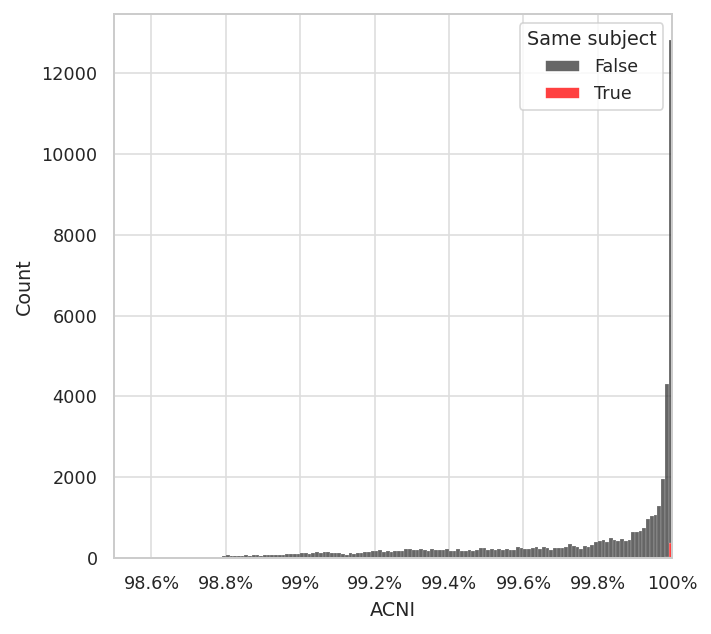

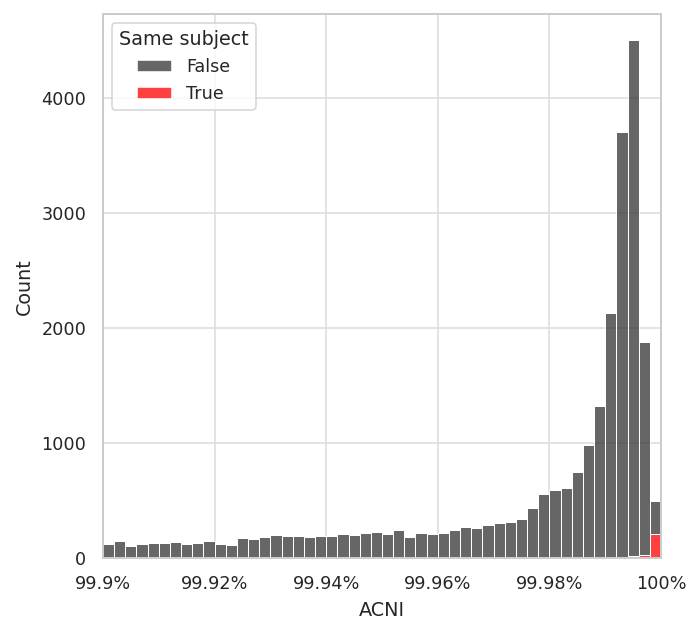

In [235]:
acni_min = round(compare_complete_df_pass_qc['singleAgreePct'].min() - 0.05, 1)
acni_max = 100.0
binsize=0.01
acni_bins = numpy.arange(acni_min, acni_max+binsize, step=binsize)

plt.figure(figsize=(5, 5))
seaborn.histplot(compare_complete_df_pass_qc.reset_index(), bins=acni_bins, x="singleAgreePct", 
                 multiple="stack", hue="same_subject", palette=["#333333", "red"])

# for spine in plt.gca().spines.values():
#     spine.set_visible(True)
    
ax = plt.gca()
ax.set_xlim(98.5, 100)
ax.set_xlabel("ACNI")
ax.xaxis.set_major_formatter("{x:g}%")
ax.get_legend().set_title("Same subject")

plt.savefig('paper_fig/entero_anci_dist_large.svg', bbox_inches='tight')

plt.figure(figsize=(5, 5))
compare_zoom = compare_complete_df_pass_qc[compare_complete_df_pass_qc['singleAgreePct'] > 99.9]

binsize2 = 0.002
bins2 = numpy.arange(99.9, 100+binsize2, binsize2)
seaborn.histplot(compare_zoom.reset_index(), bins=bins2, x="singleAgreePct", 
                 multiple="stack", hue="same_subject", palette=["#333333", "red"])
    
ax = plt.gca()
ax.set_xlim(99.9, 100)
ax.set_xlabel("ACNI")
ax.xaxis.set_major_formatter("{x:g}%")
ax.get_legend().set_title("Same subject")
plt.savefig('paper_fig/entero_anci_dist_small.svg', bbox_inches='tight')

In [236]:
display(compare_complete_df_pass_qc['singleAgreePct'].describe())
print(numpy.count_nonzero(compare_complete_df_pass_qc['singleAgreePct'] >= 99.95) / len(compare_complete_df_pass_qc))

count    48020.000000
mean        99.743070
std          0.339996
min         97.328500
25%         99.574600
50%         99.922600
75%         99.990900
max        100.000000
Name: singleAgreePct, dtype: float64

0.4462515618492295


In [237]:
print((numpy.count_nonzero(compare_complete_df_pass_qc['singleAgreePct'] >= 99.999) / len(compare_complete_df_pass_qc)) * 100)
display(compare_complete_df_pass_qc[compare_complete_df_pass_qc['singleAgreePct'] >= 99.999]['same_hospital'].value_counts(normalize=True))

0.8788004997917533


True     0.86019
False    0.13981
Name: same_hospital, dtype: float64

In [238]:
from scipy.stats import mannwhitneyu

display(between_subject_compare['singleAgreePct'].describe())
display(same_subject_compare['singleAgreePct'].describe())
mannwhitneyu(between_subject_compare['singleAgreePct'], same_subject_compare['singleAgreePct'], alternative='two-sided')

count    47547.000000
mean        99.740784
std          0.340761
min         97.328500
25%         99.569000
50%         99.919500
75%         99.990700
max        100.000000
Name: singleAgreePct, dtype: float64

count    473.000000
mean      99.972932
std        0.099320
min       99.210900
25%       99.995700
50%       99.999500
75%       99.999900
max      100.000000
Name: singleAgreePct, dtype: float64

MannwhitneyuResult(statistic=2368589.5, pvalue=2.136763618115262e-192)

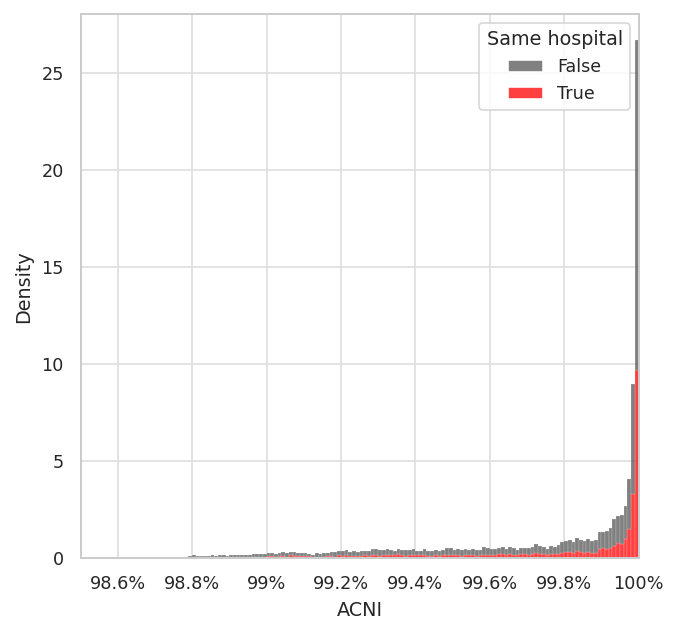

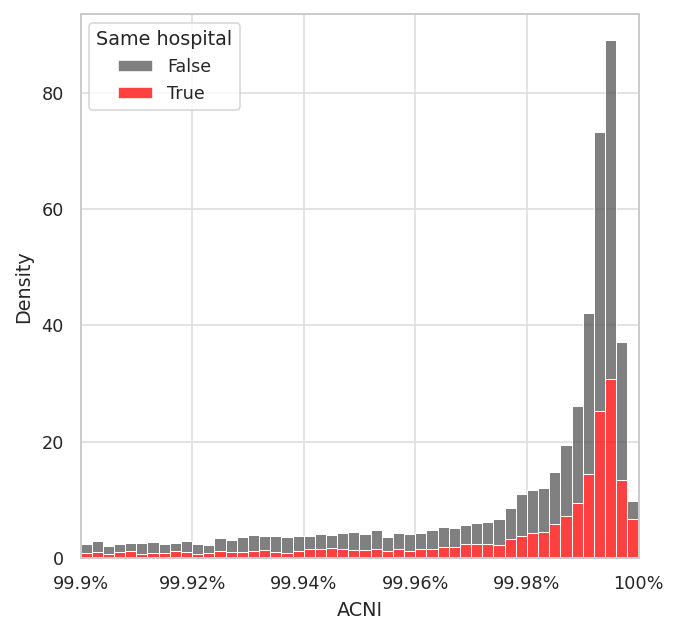

In [239]:
plt.figure(figsize=(5, 5))
seaborn.histplot(compare_complete_df_pass_qc.reset_index(), bins=acni_bins, x="singleAgreePct", stat="density",
                 multiple="stack", hue="same_hospital", palette=["#555555", "red"])

ax = plt.gca()
ax.set_xlim(98.5, 100)
ax.set_xlabel("ACNI")
ax.xaxis.set_major_formatter("{x:g}%")
ax.get_legend().set_title("Same hospital")

plt.savefig('paper_fig/entero_anci_dist_hospital_large.svg', bbox_inches='tight')

plt.figure(figsize=(5, 5))
seaborn.histplot(compare_zoom.reset_index(), bins=bins2, x="singleAgreePct", stat="density",
                 multiple="stack", hue="same_hospital", palette=["#555555", "red"])
    
ax = plt.gca()
ax.set_xlim(99.9, 100)
ax.set_xlabel("ACNI")
ax.xaxis.set_major_formatter("{x:g}%")
ax.get_legend().set_title("Same hospital")
plt.savefig('paper_fig/entero_anci_dist_hospital_small.svg', bbox_inches='tight')

In [240]:
from scipy.stats import mannwhitneyu

same_hospital_compare = compare_complete_df_pass_qc[compare_complete_df_pass_qc['same_hospital']]
diff_hospital_compare = compare_complete_df_pass_qc[~compare_complete_df_pass_qc['same_hospital']]

display(same_hospital_compare['singleAgreePct'].describe())
display(diff_hospital_compare['singleAgreePct'].describe())
mannwhitneyu(same_hospital_compare['singleAgreePct'], diff_hospital_compare['singleAgreePct'], alternative='two-sided')

count    16927.000000
mean        99.744690
std          0.345192
min         97.387300
25%         99.583050
50%         99.930100
75%         99.991300
max        100.000000
Name: singleAgreePct, dtype: float64

count    31093.000000
mean        99.742189
std          0.337136
min         97.328500
25%         99.570100
50%         99.918400
75%         99.990700
max        100.000000
Name: singleAgreePct, dtype: float64

MannwhitneyuResult(statistic=269587409.0, pvalue=9.341790366923514e-06)

0.4964185393258427


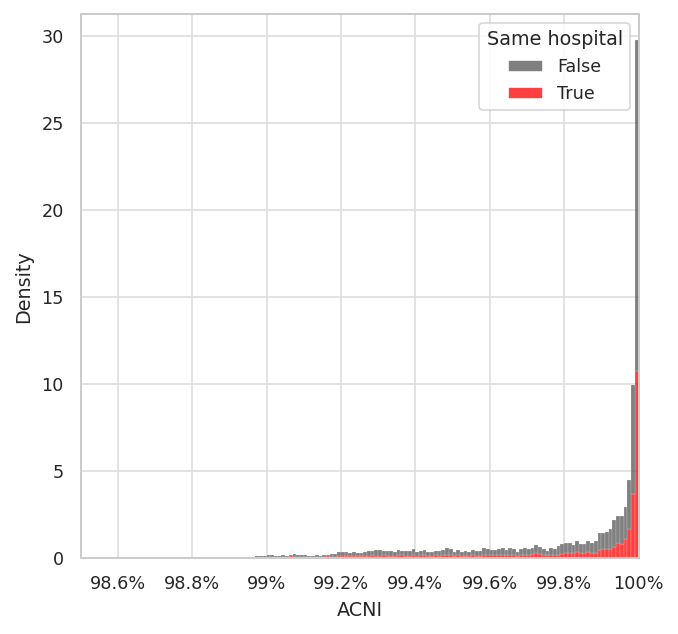

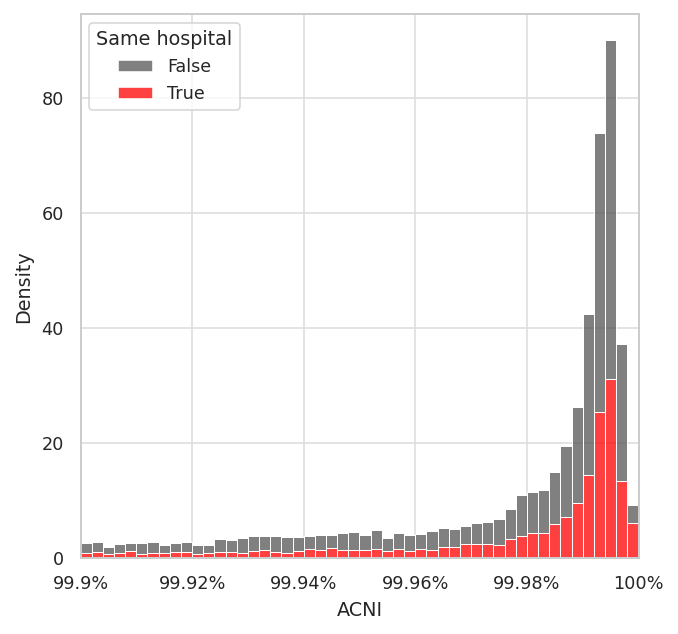

In [310]:
plt.figure(figsize=(5, 5))
efaecalis_compare_df = compare_complete_df_pass_qc[compare_complete_df_pass_qc['species'] == "faecalis"].copy()
efaecalis_zoom_df = efaecalis_compare_df[efaecalis_compare_df['singleAgreePct'] >= 99.90].copy()

seaborn.histplot(efaecalis_compare_df.reset_index(), bins=acni_bins, x="singleAgreePct", stat="density",
                 multiple="stack", hue="same_hospital", palette=["#555555", "red"])

ax = plt.gca()
ax.set_xlim(98.5, 100)
ax.set_xlabel("ACNI")
ax.xaxis.set_major_formatter("{x:g}%")
ax.get_legend().set_title("Same hospital")

plt.savefig('paper_fig/efaecalis_anci_dist_hospital_large.svg', bbox_inches='tight')

plt.figure(figsize=(5, 5))
seaborn.histplot(efaecalis_zoom_df.reset_index(), bins=bins2, x="singleAgreePct", stat="density",
                 multiple="stack", hue="same_hospital", palette=["#555555", "red"])
    
ax = plt.gca()
ax.set_xlim(99.9, 100)
ax.set_xlabel("ACNI")
ax.xaxis.set_major_formatter("{x:g}%")
ax.get_legend().set_title("Same hospital")
plt.savefig('paper_fig/efaecalis_anci_dist_hospital_small.svg', bbox_inches='tight')

print(numpy.count_nonzero(efaecalis_compare_df['singleAgreePct'] >= 99.95) / len(efaecalis_compare_df))

In [ ]:
plt.figure(figsize=(2, 5))
seaborn.boxplot(data=compare_complete_df_pass_qc.reset_index(), x="same_subject", y="singleAgreePct")
plt.xlabel("Same Subject")
plt.ylabel("Pairwise ACNI")

In [ ]:
plt.figure(figsize=(2, 5))
seaborn.boxplot(data=compare_complete_df_pass_qc.reset_index(), x="same_hospital", y="singleAgreePct")
plt.xlabel("Same Hospital")
plt.ylabel("Pairwise ACNI")

In [ ]:
seaborn.histplot(data=compare_complete_df_pass_qc.reset_index(), x="commonPct")
print(len(compare_complete_df_pass_qc[compare_complete_df_pass_qc['commonPct'] >= 25]) / len(compare_complete_df_pass_qc))

In [ ]:
seaborn.histplot(data=compare_complete_df_pass_qc.query('singleAgreePct >= 99.98').reset_index(), x="commonPct", hue="species", multiple="stack")

Text(0, 0.5, 'Fraction')

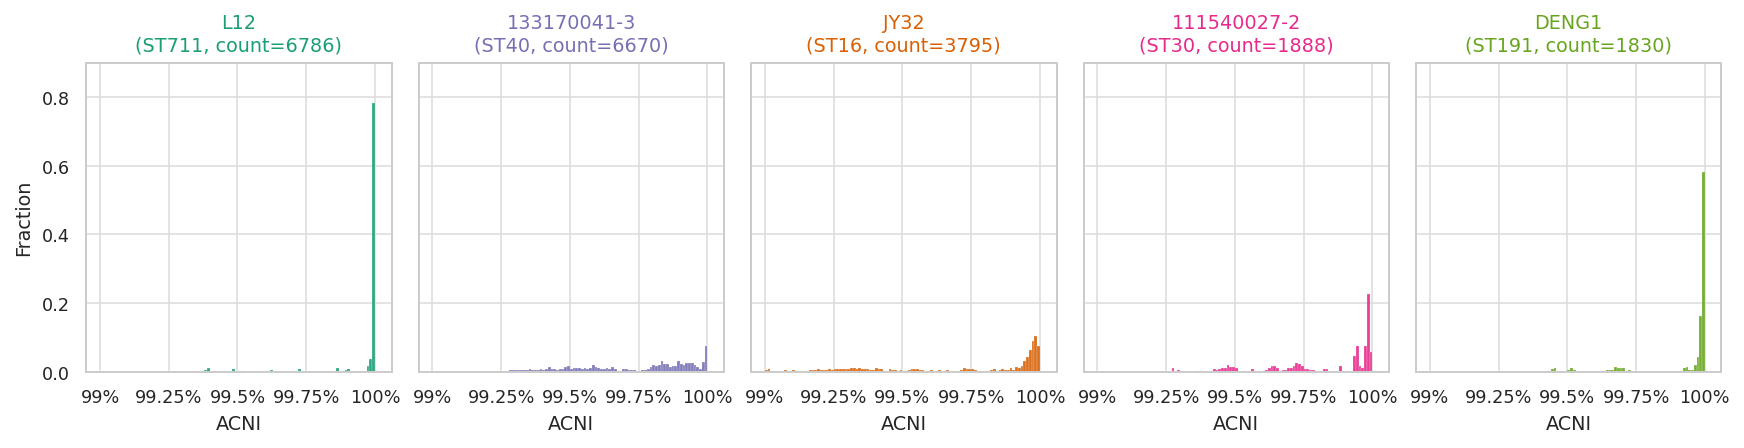

In [315]:
ref_colors = {
    "Ente_faecalis_JY32": "#d95f02",
    "Ente_faecalis_133170041-3": "#766fb4",
    "Ente_faecalis_DENG1": "#68a51f",
    "Ente_faecalis_111540027-2": "#e8298c",
    "Ente_faecalis_L12": "#1a9e76"
}

faecalis_st = compare_complete_df_pass_qc[compare_complete_df_pass_qc['species'] == 'faecalis'].dropna(subset=['st'])
faecalis_st['st'] = faecalis_st['st'].astype(int)

counts = faecalis_st.groupby(level=4).count()['sample1'].rename('count').sort_values(ascending=False)
counts = counts[counts > 25]
refs = list(counts.index)

labels = []
palette = []
for ref, count in counts.items():
    strain = ref.split('_', maxsplit=2)[2]
    st = mlst.loc[ref, 'st']
    labels.append(f"{strain} (ST{st}, count={count})") 
    palette.append(ref_colors.get(ref, "#cccccc"))
    
fig, axes = plt.subplots(1, len(ref_colors), figsize=(12, 3), constrained_layout=True, sharey=True)
binsize=0.01
bins = numpy.arange(99.0, 100+binsize, binsize)
for i, (ref, color) in enumerate(sorted(ref_colors.items(), key=lambda e: counts.loc[e[0]], reverse=True)):
    ref_df = faecalis_st.loc[(slice(None), slice(None), slice(None), slice(None), ref), :].copy()
    seaborn.histplot(data=ref_df.reset_index(), x="singleAgreePct", stat="probability", bins=bins, color=color, ax=axes[i], alpha=0.9)
    strain = ref.split('_', maxsplit=2)[2]
    st = mlst.loc[ref, 'st']
    count = counts.loc[ref]
    axes[i].set_title(f"{strain}\n(ST{st}, count={count})", color=color)
    axes[i].set_xlabel("ACNI")
    axes[i].set_ylim(0, 0.9)
    axes[i].xaxis.set_major_formatter("{x:g}%")
    
axes[0].set_ylabel("Fraction")
    
#plt.savefig('paper_fig/major_lineages_acni.svg', bbox_inches='tight')


In [109]:
straingst_df.loc[(slice(None), slice(None), 'Ente_faecalis_L12'), 'i'].value_counts()

0    123
1     14
2      2
3      1
Name: i, dtype: int64

In [ ]:
clusters = pandas.read_csv('/gsap/archive-bacterial/Projects/StrainGE/refseq/enterococcus/strainge_db/clusters.tsv', sep='\t', header=None, index_col=0).T

clustered_mlst = []
for ref in clusters:
    for clustered_ref in clusters[ref]:
        if clustered_ref in mlst.index:
            orig = mlst.loc[clustered_ref, 'st']
            new = mlst.loc[ref, 'st']
            
            if orig != new:
                clustered_mlst.append({
                    'orig': mlst.loc[clustered_ref, 'st'],
                    'new': mlst.loc[ref, 'st']
                })

clustered_mlst_df = pandas.DataFrame(clustered_mlst).set_index('orig')

with pandas.option_context('display.max_rows', None):
    display(clustered_mlst_df)

In [ ]:
to_keep = list(set(mlst.index) & set(clusters.columns))
mlst_in_db = mlst.loc[to_keep, :]
mlst_in_db[mlst_in_db['st'] == 40]

## Compare ACNI to ANI between isolate assemblies

### First some MOB-suite results

In [325]:
total_sequence = 0
total_plasmid = 0

plasmid_sizes = []

for f in (BASE_PATH / "assemblies/isolates/").glob("**/contig_report.txt"):
    df = pandas.read_csv(f, sep='\t')
    total_sequence += df['size'].sum()
    
    plasmid_size = df[df['molecule_type'] == "plasmid"]['size'].sum()
    plasmid_sizes.append(plasmid_size)
    total_plasmid +=  plasmid_size
    
print(total_plasmid, "/", total_sequence, (total_plasmid / total_sequence) * 100)

31681413 / 1447142252 2.1892397209890877
70717.43973214286


In [326]:
plasmid_sizes_arr = numpy.array(plasmid_sizes)
print(plasmid_sizes_arr.mean())
print(plasmid_sizes_arr.std())

70717.43973214286
63576.6857825968


### Load isolate metadata

In [299]:
isolate_ena = pandas.read_csv(BASE_PATH / "data/isolates_ena.txt", sep='\t', index_col='secondary_sample_accession')
isolate_meta = pandas.read_csv(BASE_PATH / "data/isolates_meta.txt", sep='\t', index_col='Sample_ID')
isolate_meta['Time_point'] = isolate_meta['Sample_timepoints'].map(lambda e: e.split('_')[-1].replace("M", "Mother")).astype(timepoint_dtype)
isolate_meta = isolate_ena.join(isolate_meta).reset_index().set_index(['run_accession'])

In [176]:
isolate_samples_df, isolate_straingst = straingst_to_df(STRAINGST_PATH.glob("isolates/*.tsv"))
isolate_straingst['species'] = isolate_straingst.index.map(lambda ix: ix[1].split('_')[1])
isolate_straingst = isolate_straingst.join(isolate_meta, on='sample', how='left').reset_index().set_index(
    ['Subject_ID', 'Time_point', 'i', 'strain']).sort_index().reset_index(level=2)
isolate_straingst_first = isolate_straingst[isolate_straingst['i'] == 0].copy()
isolate_straingst_first

i      sample  gkmers  \
Subject_ID Time_point strain                                                
A00021_T1  21         Ente_faecalis_111540027-2     0  ERR3403216   28954   
                      Ente_faecalis_JY32            0  ERR3403215   28954   
                      Ente_faecium_UAMSEF_01        0  ERR3402783   26437   
A00021_T2  4          Ente_faecalis_JY32            0  ERR3403219   28954   
           7          Ente_faecalis_111540027-2     0  ERR3402591   28954   
...                                                ..         ...     ...   
C02756     Mother     Ente_faecalis_NCTC8745        0  ERR3402884   26892   
                      Ente_faecium_3012STDY6244127  0  ERR3402868   24667   
           7          Ente_faecalis_JY32            0  ERR3403270   28954   
C02892     7          Ente_faecalis_JY32            0  ERR3403305   28954   
                      Ente_faecium_3012STDY6244127  0  ERR3403269   24667   

                                                    ikmers  skmers    cov  \
Subject_ID Time_point strain                                                
A00021_T1  21         Ente_faecalis_111540027-2      28953   34920  0.939   
                      Ente_faecalis_JY32             28946   32515  0.968   
                      Ente_faecium_UAMSEF_01         26353   41960  0.911   
A00021_T2  4          Ente_faecalis_JY32             28946   33115  0.971   
           7          Ente_faecalis_111540027-2      28943   39872  0.967   
...                                                    ...     ...    ...   
C02756     Mother     Ente_faecalis_NCTC8745         26890   33394  0.945   
                      Ente_faecium_3012STDY6244127   24604   45727  0.884   
           7          Ente_faecalis_JY32             28953   32451  0.909   
C02892     7          Ente_faecalis_JY32             28950   30962  0.968   
                      Ente_faecium_3012STDY6244127   24646   34177  0.882   

                                                       kcov     gcov   acct  \
Subject_ID Time_point strain                                                  
A00021_T1  21         Ente_faecalis_111540027-2      99.608   92.095  0.931   
                      Ente_faecalis_JY32            119.993  114.606  0.987   
                      Ente_faecium_UAMSEF_01         56.887   49.750  0.880   
A00021_T2  4          Ente_faecalis_JY32            103.714   99.334  0.986   
           7          Ente_faecalis_111540027-2      81.377   77.675  0.900   
...                                                     ...      ...    ...   
C02756     Mother     Ente_faecalis_NCTC8745         75.504   70.539  0.902   
                      Ente_faecium_3012STDY6244127   78.928   68.563  0.793   
           7          Ente_faecalis_JY32             68.783   61.627  0.879   
C02892     7          Ente_faecalis_JY32             77.816   74.297  0.987   
                      Ente_faecium_3012STDY6244127   71.831   61.691  0.804   

                                                     even  ...  \
Subject_ID Time_point strain                               ...   
A00021_T1  21         Ente_faecalis_111540027-2     0.939  ...   
                      Ente_faecalis_JY32            0.968  ...   
                      Ente_faecium_UAMSEF_01        0.911  ...   
A00021_T2  4          Ente_faecalis_JY32            0.971  ...   
           7          Ente_faecalis_111540027-2     0.967  ...   
...                                                   ...  ...   
C02756     Mother     Ente_faecalis_NCTC8745        0.945  ...   
                      Ente_faecium_3012STDY6244127  0.884  ...   
           7          Ente_faecalis_JY32            0.909  ...   
C02892     7          Ente_faecalis_JY32            0.968  ...   
                      Ente_faecium_3012STDY6244127  0.882  ...   

                                                                                            fastq_ftp  \
Subject_ID Time_point strain                            

In [317]:
isolate_counts = isolate_straingst_first['Sample_timepoints'].value_counts()
display(isolate_counts)

B00268_21      7
B01042_M       5
B00537_M       5
A01057_21      4
A00908_T1_4    4
              ..
B00020_21      1
B00088_7       1
A00185_4       1
B01089_7       1
B00012_4       1
Name: Sample_timepoints, Length: 294, dtype: int64

In [ ]:
isolate_straingst[isolate_straingst['sample'] == "ERR3402658"]

In [182]:
isolates_entero = isolate_meta[isolate_meta['Taxonomy_group'].str.startswith('Enterococcus')].copy()
isolates_entero['species'] = isolates_entero['Taxonomy_group'].map(lambda e: e.split()[1])

isolates_entero['species'].value_counts(normalize=True) * 100

faecalis         78.651685
faecium          13.707865
durans            3.595506
casseliflavus     2.247191
gallinarum        1.573034
mundtii           0.224719
Name: species, dtype: float64

In [ ]:
with pandas.option_context('display.max_rows', None):
    display(isolate_straingst_first)

In [202]:
def phylip_to_matrix(f):
    fiter = iter(f)
    num_entries = int(next(fiter))
    reference_names = []
    
    matrix = numpy.zeros((num_entries, num_entries))
    for i, line in enumerate(fiter):
        parts = line.strip().split('\t')
        reference_names.append(parts[0])
        row = numpy.array([float(v) if v != "NA" else numpy.nan for v in parts[1:]])
        if len(row) > 0:
            matrix[i, 0:len(row)] = row
        
    index_upper = numpy.triu_indices(num_entries)
    matrix[index_upper] = matrix.T[index_upper]
    
    return pandas.DataFrame(matrix, index=reference_names, columns=reference_names)

with open(BASE_PATH / "assemblies/fastani_chrom.output.matrix") as f:
    isolate_ani_matrix = phylip_to_matrix(f)
    isolate_ani_matrix.index = isolate_ani_matrix.index.map(lambda ix: ix.split('/')[1])
    isolate_ani_matrix.columns = isolate_ani_matrix.columns.map(lambda ix: ix.split('/')[1])
    
fastani_df = pandas.read_csv(BASE_PATH / "assemblies/fastani_chrom.output", sep='\t', names=['sample1', 'sample2', 'ani', 'shared_fragments', 'total_fragments'])
fastani_df['sample1'] = fastani_df['sample1'].map(lambda e: e.split('/')[1])
fastani_df['sample2'] = fastani_df['sample2'].map(lambda e: e.split('/')[1])
fastani_df['aligned_fraction'] = fastani_df['shared_fragments'] / fastani_df['total_fragments']
fastani_df = fastani_df.set_index(['sample1', 'sample2'])

print(fastani_df['aligned_fraction'].describe())
print(numpy.count_nonzero(fastani_df['aligned_fraction'] < 0.25), "/", len(fastani_df))

print(fastani_df['ani'].describe())

for s1, s2 in fastani_df[fastani_df['aligned_fraction'] < 0.25].index:
    isolate_ani_matrix.loc[s1, s2] = numpy.nan
    isolate_ani_matrix.loc[s2, s1] = numpy.nan
    
isolate_ani_matrix

count    137481.000000
mean          0.856135
std           0.145266
min           0.012737
25%           0.867076
50%           0.891641
75%           0.914316
max           1.000000
Name: aligned_fraction, dtype: float64
927 / 137481
count    137481.000000
mean         98.424828
std           2.754765
min          77.166300
25%          98.617100
50%          98.802200
75%          98.970800
max         100.000000
Name: ani, dtype: float64


,ERR3402561,ERR3402562,ERR3402563,ERR3402564,ERR3402565,ERR3402566,ERR3402567,ERR3402568,ERR3402569,ERR3402570,...,ERR3403320,ERR3403321,ERR3403322,ERR3403323,ERR3403325,ERR3403326,ERR3403328,ERR3403329,ERR3403330,ERR3403354
ERR3402561,0.000000,98.764069,99.946182,98.846092,98.880272,98.930458,98.784348,98.505424,98.859390,99.931007,...,NaN,NaN,98.702782,98.683105,99.899605,98.549973,98.831284,98.698830,98.902710,99.494514
ERR3402562,98.764069,0.000000,98.788727,99.289948,98.769379,99.000038,99.994110,98.567398,99.106445,98.785042,...,NaN,NaN,99.039406,98.895103,98.672272,98.557297,99.024612,98.902481,99.121262,98.934235
ERR3402563,99.946182,98.788727,0.000000,98.781448,98.915161,98.905525,98.787216,98.436295,98.832054,99.969955,...,NaN,NaN,98.584343,98.644348,99.796478,98.598022,98.803055,98.656799,98.913956,99.431549
ERR3402564,98.846092,99.289948,98.781448,0.000000,99.036308,98.822006,99.311577,98.503235,98.875076,98.806229,...,NaN,NaN,98.731873,98.681976,98.674133,98.474304,98.825638,98.712852,98.857704,98.699860
ERR3402565,98.880272,98.769379,98.915161,99.036308,0.000000,98.870644,98.742783,98.577240,98.776978,98.902893,...,NaN,NaN,98.599556,99.197952,98.732697,98.547348,98.842880,98.647766,98.834526,98.752472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR3403326,98.549973,98.557297,98.598022,98.474304,98.547348,98.609482,98.548798,98.577225,98.551788,98.552338,...,NaN,NaN,98.530518,98.486511,98.510925,0.000000,98.597260,98.552162,98.504555,98.662445
ERR3403328,98.831284,99.024612,98.803055,98.825638,98.842880,99.005997,98.960274,98.598495,99.131744,98.819809,...,NaN,NaN,99.017265,98.898499,98.637680,98.597260,0.000000,99.911514,99.101700,98.897232
ERR3403329,98.698830,98.902481,98.656799,98.712852,98.647766,98.820671,98.823410,98.545319,98.951141,98.665482,...,99.196274,94.650375,98.853401,98.838387,96.873856,98.552162,99.911514,0.000000,98.842178,98.789276
ERR3403330,98.902710,99.121262,98.913956,98.857704,98.834526,99.246292,99.109612,98.488281,99.948563,98.969398,...,NaN,NaN,98.955887,98.933128,98.822266,98.504555,99.101700,98.842178,0.000000,98.815926


In [242]:
from itertools import product

def get_isolate_ani(ix):
    subject1, subject2, sample1, sample2, ref = ix
    
    ix1 = (subject1, sample1, ref)
    ix2 = (subject2, sample2, ref)
    
    if ix1 in isolate_straingst_first.index and ix2 in isolate_straingst_first.index:
        samples1 = list(isolate_straingst_first.loc[ix1, 'sample'])
        samples2 = list(isolate_straingst_first.loc[ix2, 'sample'])
        
        samples1 = [s for s in samples1 if s in isolate_ani_matrix.index]
        samples2 = [s for s in samples2 if s in isolate_ani_matrix.index]
        
        if samples1 and samples2:
            max_ani = max(isolate_ani_matrix.loc[s1, s2] for s1, s2 in product(samples1, samples2))
            return max_ani
    
    return numpy.nan

compare_complete_df_pass_qc['isolate_ani'] = compare_complete_df_pass_qc.index.map(get_isolate_ani)

/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(0.9498878802028033, 0.0)


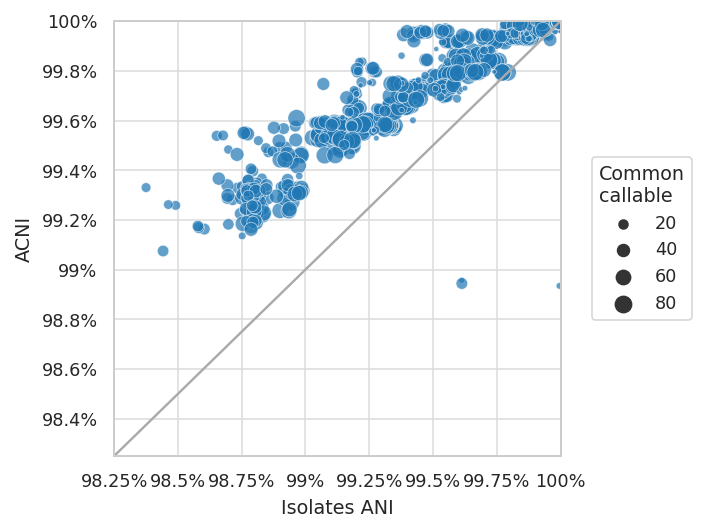

In [243]:
from scipy.stats import pearsonr
import statsmodels as sm
import statsmodels.formula.api as smf

compare_with_ani = compare_complete_df_pass_qc[~compare_complete_df_pass_qc['isolate_ani'].isna()].copy()
print(pearsonr(compare_with_ani['isolate_ani'], compare_with_ani['singleAgreePct']))

plt.figure(figsize=(4, 4))
lim = (98.25, 100)
plt.plot(list(lim), list(lim), color='#aaa')
seaborn.scatterplot(data=compare_with_ani, x="isolate_ani", y="singleAgreePct", size="commonPct", sizes=(5, 80), alpha=0.7)
plt.xlim(*lim)
plt.ylim(*lim)
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title="Common\ncallable")
plt.gca().xaxis.set_major_formatter("{x:g}%")
plt.gca().yaxis.set_major_formatter("{x:g}%")
plt.xlabel("Isolates ANI")
plt.ylabel("ACNI")
plt.savefig('paper_fig/acni_vs_ani_entero.svg', bbox_inches='tight')

In [198]:
compare_with_ani.sample(10)

,,,,,sample1,sample2,scaffold,length,common,commonPct,single,singlePct,singleAgree,singleAgreePct,...,same_subject,straingst_present,enough_cov,nice_name,hospital1,hospital2,same_hospital,species,st,isolate_ani
subject1,subject2,tp1,tp2,ref,,,,,,,,,,,,,,,,,,,,,
A01105,A01583,4,7,Ente_faecalis_L12,ERR3405131,ERR3405250,NZ_CP018102.1,2668255,583823,21.8803,583789,99.9942,583640,99.9745,...,False,True,True,E. faecalis L12,A,A,True,faecalis,711.0,99.949493
A00043,A01105,7,4,Ente_faecalis_L12,ERR3404793,ERR3405131,NZ_CP018102.1,2668255,1684429,63.1285,1684290,99.9917,1684138,99.9910,...,False,True,True,E. faecalis L12,A,A,True,faecalis,711.0,99.971283
A01057,B01278,4,21,Ente_faecium_3012STDY6244127,ERR3405125,ERR3405109,NZ_LR215968.1,2545110,2295231,90.1820,2294609,99.9729,2277930,99.2731,...,False,True,True,E. faecium 3012STDY6244127,A,B,False,faecium,160.0,98.944626
B01339,C01387,21,Mother,Ente_faecalis_NCTC8745,ERR3405178,ERR3405225,NZ_LR134312.1,2719199,118992,4.3760,118988,99.9966,118667,99.7302,...,False,True,True,E. faecalis NCTC8745,B,C,False,faecalis,22.0,99.625702
C01930,C01930,4,7,Ente_faecalis_SF28073,ERR3405438,ERR3405439,NZ_CP060804.1,3039501,2655898,87.3794,2655533,99.9863,2655533,100.0000,...,True,True,True,E. faecalis SF28073,C,C,True,faecalis,2.0,99.997765
B00097,B01956,21,4,Ente_faecalis_NCTC8745,ERR3404841,ERR3405388,NZ_LR134312.1,2719199,230051,8.4602,230040,99.9952,229122,99.6009,...,False,True,True,E. faecalis NCTC8745,B,B,True,faecalis,22.0,99.421387
A01739,C01913,7,7,Ente_faecalis_111540027-2,ERR3405354,ERR3405421,NZ_CP046112.1,2937521,2257683,76.8567,2257524,99.9930,2256000,99.9325,...,False,True,True,E. faecalis 111540027-2,A,C,False,faecalis,30.0,99.828522
A01166,B00550,4,21,Ente_faecalis_SGAir0397,ERR3405046,ERR3404969,NZ_CP039434.1,2696714,1525694,56.5760,1525330,99.9761,1524525,99.9472,...,False,True,True,E. faecalis SGAir0397,A,B,False,faecalis,314.0,99.869415
A00031,C01052,21,4,Ente_faecalis_L12,ERR3404924,ERR3405022,NZ_CP018102.1,2668255,707848,26.5285,707694,99.9782,707654,99.9943,...,False,True,True,E. faecalis L12,A,C,False,faecalis,711.0,99.981934


In [185]:
display(isolate_straingst.loc[("B00235", "7"), :])
display(isolate_straingst.loc[("C01529", "4"), :])

,i,sample,gkmers,ikmers,skmers,cov,kcov,gcov,acct,even,...,fastq_ftp,fastq_aspera,submitted_ftp,sra_ftp,sample_title,Sample_timepoints,Taxonomy_group,Delivery_mode,Source,Hospital
strain,,,,,,,,,,,,,,,,,,,,,
Ente_faecalis_133170041-3,0,ERR3402608,28659,28657,39591,0.9,94.116,83.359,0.855,0.9,...,ftp.sra.ebi.ac.uk/vol1/fastq/ERR340/008/ERR340...,fasp.sra.ebi.ac.uk:/vol1/fastq/ERR340/008/ERR3...,ftp.sra.ebi.ac.uk/vol1/run/ERR340/ERR3402608/2...,NaN,B00235_7,B00235_7,Enterococcus faecalis,Vaginal,Neonatal,B


,i,sample,gkmers,ikmers,skmers,cov,kcov,gcov,acct,even,...,fastq_ftp,fastq_aspera,submitted_ftp,sra_ftp,sample_title,Sample_timepoints,Taxonomy_group,Delivery_mode,Source,Hospital
strain,,,,,,,,,,,,,,,,,,,,,
Ente_faecalis_133170041-3,0,ERR3403094,28659,28646,35180,0.999,87.437,86.244,0.966,0.999,...,ftp.sra.ebi.ac.uk/vol1/fastq/ERR340/004/ERR340...,fasp.sra.ebi.ac.uk:/vol1/fastq/ERR340/004/ERR3...,ftp.sra.ebi.ac.uk/vol1/run/ERR340/ERR3403094/2...,NaN,C01529_4,C01529_4,Enterococcus faecalis,Caesarean,Neonatal,C


## Check for potential maternal strain transmission

In [260]:
species_counter = defaultdict(int)

for ref in itertools.chain.from_iterable(individuals_with_shared_strain_mother.values()):
    species = ref.split('_')[1]
    species_counter[species] += 1
    
species_counter

defaultdict(int, {'faecalis': 11, 'faecium': 4, 'durans': 3})

In [261]:
from collections import Counter

print(len(individuals_with_shared_strain_mother))
ref_counter = Counter(itertools.chain.from_iterable(individuals_with_shared_strain_mother.values()))
print([(k, v) for k, v in sorted(ref_counter.items(), key=lambda e: e[1], reverse=True)])

17
[('Ente_durans_KCTC_13289', 3), ('Ente_faecalis_L12', 2), ('Ente_faecium_DMEA02', 2), ('Ente_faecalis_LD33', 2), ('Ente_faecalis_NCTC8732', 2), ('Ente_faecalis_SGAir0397', 1), ('Ente_faecium_NCTC7174', 1), ('Ente_faecalis_FDAARGOS_324', 1), ('Ente_faecalis_Symbioflor_1', 1), ('Ente_faecalis_KUB3006', 1), ('Ente_faecalis_133170041-3', 1), ('Ente_faecium_3012STDY6244127', 1)]


In [263]:
for individual, refs in individuals_with_shared_strain_mother.items():
    print(individual)
    ix = (individual, individual)
    
    if ix not in compare_complete_df_pass_qc.index:
        continue
        
    within_subject_compare = compare_complete_df_pass_qc.loc[ix, :].copy()
    
    for ref in refs:
        if ref in set(within_subject_compare.index.unique(level=2)):
            print(ref)
            display(within_subject_compare.loc[(slice(None), slice(None), ref), :])
            
    print()

606141
Ente_faecalis_SGAir0397


/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


,,,sample1,sample2,scaffold,length,common,commonPct,single,singlePct,singleAgree,singleAgreePct,...,same_subject,straingst_present,enough_cov,nice_name,hospital1,hospital2,same_hospital,species,st,isolate_ani
tp1,tp2,ref,,,,,,,,,,,,,,,,,,,,,
4,Mother,Ente_faecalis_SGAir0397,ERR3404633,ERR3404665,NZ_CP039434.1,2696714,174483,6.4702,174183,99.8281,174176,99.996,...,True,True,True,E. faecalis SGAir0397,A,A,True,faecalis,314.0,NaN



A00576
Ente_faecium_NCTC7174


/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/ipykernel/zmqshell.py:539: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


,,,sample1,sample2,scaffold,length,common,commonPct,single,singlePct,singleAgree,singleAgreePct,...,same_subject,straingst_present,enough_cov,nice_name,hospital1,hospital2,same_hospital,species,st,isolate_ani
tp1,tp2,ref,,,,,,,,,,,,,,,,,,,,,
Mother,4,Ente_faecium_NCTC7174,ERR3404962,ERR3404976,NZ_LR134337.1,2450323,218009,8.8972,217992,99.9922,217390,99.7238,...,True,True,True,E. faecium NCTC7174,A,A,True,faecium,1034.0,NaN



A02064
Ente_faecalis_L12


/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/ipykernel/zmqshell.py:539: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


sample1     sample2       scaffold   length  \
tp1 tp2 ref                                                                 
4   7   Ente_faecalis_L12  ERR3405459  ERR3405460  NZ_CP018102.1  2668255   
21  7   Ente_faecalis_L12  ERR3405458  ERR3405460  NZ_CP018102.1  2668255   
    4   Ente_faecalis_L12  ERR3405458  ERR3405459  NZ_CP018102.1  2668255   

                           common  commonPct  single  singlePct  singleAgree  \
tp1 tp2 ref                                                                    
4   7   Ente_faecalis_L12  260829     9.7753  260827    99.9992       260827   
21  7   Ente_faecalis_L12  178076     6.6739  178036    99.9775       177876   
    4   Ente_faecalis_L12   91056     3.4126   91040    99.9824        90949   

                           singleAgreePct  ...  same_subject  \
tp1 tp2 ref                                ...                 
4   7   Ente_faecalis_L12        100.0000  ...          True   
21  7   Ente_faecalis_L12         99.9101  ...          True   
    4   Ente_faecalis_L12         99.9000  ...          True   

                           straingst_present  enough_cov        nice_name  \
tp1 tp2 ref                                                                 
4   7   Ente_faecalis_L12               True        True  E. faecalis L12   
21  7   Ente_faecalis_L12               True        True  E. faecalis L12   
    4   Ente_faecalis_L12               True        True  E. faecalis L12   

                           hospital1  hospital2  same_hospital   species  \
tp1 tp2 ref                                                                
4   7   Ente_faecalis_L12          A          A           True  faecalis   
21  7   Ente_faecalis_L12          A          A           True  faecalis   
    4   Ente_faecalis_L12          A          A           True  faecalis   

                              st  isolate_ani  
tp1 tp2 ref                                    
4   7   Ente_faecalis_L12  711.0          NaN  
21  7   Ente_faecalis_L12  711.0          NaN  
    4   Ente_faecalis_L12  711.0          NaN  

[3 rows x 39 columns]


B00046
B00922
B01471
Ente_faecalis_L12


/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/ipykernel/zmqshell.py:539: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


,,,sample1,sample2,scaffold,length,common,commonPct,single,singlePct,singleAgree,singleAgreePct,...,same_subject,straingst_present,enough_cov,nice_name,hospital1,hospital2,same_hospital,species,st,isolate_ani
tp1,tp2,ref,,,,,,,,,,,,,,,,,,,,,
Mother,7,Ente_faecalis_L12,ERR3405145,ERR3405157,NZ_CP018102.1,2668255,531396,19.9155,531364,99.994,531364,100.0,...,True,True,True,E. faecalis L12,B,B,True,faecalis,711.0,NaN


Ente_faecalis_FDAARGOS_324


,,,sample1,sample2,scaffold,length,common,commonPct,single,singlePct,singleAgree,singleAgreePct,...,same_subject,straingst_present,enough_cov,nice_name,hospital1,hospital2,same_hospital,species,st,isolate_ani
tp1,tp2,ref,,,,,,,,,,,,,,,,,,,,,
Mother,7,Ente_faecalis_FDAARGOS_324,ERR3405145,ERR3405157,NZ_CP028285.1,2928142,34116,1.1651,34097,99.9443,34064,99.9032,...,True,True,True,E. faecalis FDAARGOS 324,B,B,True,faecalis,776.0,NaN



B02159

C01443
C01485
Ente_faecalis_LD33


/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/ipykernel/zmqshell.py:539: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


,,,sample1,sample2,scaffold,length,common,commonPct,single,singlePct,singleAgree,singleAgreePct,...,same_subject,straingst_present,enough_cov,nice_name,hospital1,hospital2,same_hospital,species,st,isolate_ani
tp1,tp2,ref,,,,,,,,,,,,,,,,,,,,,
7,21,Ente_faecalis_LD33,ERR3405765,ERR3405773,NZ_CP014949.1,2803429,2721229,97.0679,2720820,99.985,2720818,99.9999,...,True,True,True,E. faecalis LD33,C,C,True,faecalis,25.0,NaN



C01758
Ente_faecalis_Symbioflor_1


/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/ipykernel/zmqshell.py:539: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


,,,sample1,sample2,scaffold,length,common,commonPct,single,singlePct,singleAgree,singleAgreePct,...,same_subject,straingst_present,enough_cov,nice_name,hospital1,hospital2,same_hospital,species,st,isolate_ani
tp1,tp2,ref,,,,,,,,,,,,,,,,,,,,,
21,7,Ente_faecalis_Symbioflor_1,ERR3405526,ERR3405528,NC_019770.1,2810675,297899,10.5988,297783,99.9611,297766,99.9943,...,True,True,True,E. faecalis Symbioflor 1,C,C,True,faecalis,248.0,NaN



C01930
Ente_faecium_DMEA02


/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/ipykernel/zmqshell.py:539: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


,,,sample1,sample2,scaffold,length,common,commonPct,single,singlePct,singleAgree,singleAgreePct,...,same_subject,straingst_present,enough_cov,nice_name,hospital1,hospital2,same_hospital,species,st,isolate_ani
tp1,tp2,ref,,,,,,,,,,,,,,,,,,,,,
7,Mother,Ente_faecium_DMEA02,ERR3405439,ERR3405440,NZ_CP043484.1,2573925,2420738,94.0485,2420416,99.9867,2420408,99.9997,...,True,True,True,E. faecium DMEA02,C,C,True,faecium,178.0,NaN



C02047

C02056

C02058
C02295
Ente_durans_KCTC_13289


/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/ipykernel/zmqshell.py:539: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


,,,sample1,sample2,scaffold,length,common,commonPct,single,singlePct,singleAgree,singleAgreePct,...,same_subject,straingst_present,enough_cov,nice_name,hospital1,hospital2,same_hospital,species,st,isolate_ani
tp1,tp2,ref,,,,,,,,,,,,,,,,,,,,,
Mother,Infancy,Ente_durans_KCTC_13289,ERR3405679,ERR3406075,NZ_CP065535.1,2923777,574910,19.6633,573979,99.8381,571763,99.6139,...,True,True,True,E. durans KCTC 13289,C,C,True,durans,NaN,NaN



C02756
S7


/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/ipykernel/zmqshell.py:539: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


## Focus on subject C01930, for which we could track a strain from mother to child

Two references were reported at multiple time points in this subject: *E. faecium DMEA02* and *E. faecalis SF28073*, let's see which other subjects have strains close to those references too.

In [ ]:
with pandas.option_context('display.max_columns', None):
    display(straingst_df.loc['C01930'])

### StrainGST results from other subjects with either DMEA02 or SF28073


In [128]:
selected_refs = ['Ente_faecium_DMEA02', 'Ente_faecalis_SF28073']
subjects_with_selected_strains = list(without_infancy_df.loc[(slice(None), slice(None), selected_refs), :].index.unique(level=0))
print(subjects_with_selected_strains)
straingst_select = without_infancy_df.loc[subjects_with_selected_strains, :]
seen_strains = list(sorted(straingst_select.index.unique(level=2)))
seen_strains = list(map(nice_ref_name, seen_strains))

strains_per_species = defaultdict(list)
for strain in seen_strains:
    species = strain.split(' ')[1]
    strains_per_species[species].append(strain)
    
print(strains_per_species.keys())
    
colorblind_palette = seaborn.color_palette("colorblind")
palette = colorblind_palette[2:4] + colorblind_palette[0:2] + colorblind_palette[4:]
colormap_per_species = {
    species: seaborn.light_palette(palette[i % 10], n_colors=len(strains)+2, reverse=True, input='rgb')[:len(strains)]
    for i, (species, strains) in enumerate(strains_per_species.items())
}

strain_colors = [rgb2hex(c) for c in itertools.chain.from_iterable(colormap_per_species.values())]
strain_color_map = dict(zip(seen_strains, strain_colors))

vaginal_df = straingst_select[straingst_select['Delivery_mode'] == "Vaginal"]
vaginal_strains = list(map(nice_ref_name, sorted(vaginal_df.index.unique(level=2))))
vaginal_colors = [strain_color_map[s] for s in vaginal_strains]
vaginal_color_scale = alt.Scale(domain=vaginal_strains, range=vaginal_colors)

vaginal_chart = alt.Chart(vaginal_df.reset_index()).mark_bar(clip=True).encode(
    x=alt.X('Time_point:O', title="Time point", sort=timepoints),
    y=alt.Y('sum(rapct):Q', title="Relative abundance", axis=alt.Axis(labelExpr="datum.label + '%'"), scale=alt.Scale(domain=[0, 100])),
    color=alt.Color('nice_name:N', scale=vaginal_color_scale, title="Strain"),
    tooltip=['strain', 'sample']
).properties(
    title="StrainGST results for vaginal born children",
    width=100,
    height=100,
).facet(
    facet='Individual:N',
    columns=5
).resolve_scale(
    x='shared',
    y='shared'
)

display(vaginal_chart)

caesarean_df = straingst_select[straingst_select['Delivery_mode'] == "Caesarean"]
caesarean_strains = list(map(nice_ref_name, sorted(caesarean_df.index.unique(level=2))))
caesarean_colors = [strain_color_map[s] for s in caesarean_strains]
caesarean_color_scale = alt.Scale(domain=caesarean_strains, range=caesarean_colors)

caesarean_chart = alt.Chart(caesarean_df.reset_index()).mark_bar(clip=True).encode(
    x=alt.X('Time_point:O', title="Time point", sort=timepoints),
    y=alt.Y('sum(rapct):Q', title="Relative abundance", axis=alt.Axis(labelExpr="datum.label + '%'"), scale=alt.Scale(domain=[0, 100])),
    color=alt.Color('nice_name:N', scale=caesarean_color_scale, title="Strain"),
    tooltip=['strain', 'sample']
).properties(
    title="StrainGST results for caesarean born children",
    width=100,
    height=100,
).facet(
    facet='Individual:N',
    columns=5
).resolve_scale(
    x='shared',
    y='shared'
)

display(caesarean_chart)


['A01082', 'A01107', 'A01580', 'A01671', 'A01966', 'B00046', 'B00252', 'B00922', 'B01236', 'B02109', 'BBS0074', 'C01070', 'C01841', 'C01930', 'C02143', 'C02471']
dict_keys(['avium', 'durans', 'faecalis', 'faecium'])


alt.FacetChart(...)

alt.FacetChart(...)

In [161]:
vaginal_chart = alt.Chart(vaginal_df.reset_index()).mark_bar(clip=True).encode(
    x=alt.X('Time_point:O', title="Time point", sort=timepoints),
    y=alt.Y('sum(rapct):Q', title="Relative abundance", axis=alt.Axis(labelExpr="datum.label + '%'"), scale=alt.Scale(domain=[0, 35])),
    color=alt.Color('nice_name:N', scale=vaginal_color_scale, title="Strain"),
    tooltip=['strain', 'sample', 'rapct']
).properties(
    title="StrainGST results for vaginal born children",
    width=75,
    height=200,
).facet(
    facet='Individual:N',
    columns=4
).resolve_scale(
    x='shared',
    y='shared'
)

display(vaginal_chart)

caesarean_chart = alt.Chart(caesarean_df.reset_index()).mark_bar(clip=True).encode(
    x=alt.X('Time_point:O', title="Time point", sort=timepoints),
    y=alt.Y('sum(rapct):Q', title="Relative abundance", axis=alt.Axis(labelExpr="datum.label + '%'"), scale=alt.Scale(domain=[0, 35])),
    color=alt.Color('nice_name:N', scale=caesarean_color_scale, title="Strain"),
    tooltip=['strain', 'sample', 'rapct']
).properties(
    title="StrainGST results for caesarean born children",
    width=75,
    height=200,
).facet(
    facet='Individual:N',
    columns=4
).resolve_scale(
    x='shared',
    y='shared'
)

display(caesarean_chart)


alt.FacetChart(...)

alt.FacetChart(...)

/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/ipykernel_launcher.py:89: PerformanceWarning: indexing past lexsort depth may impact performance.


('Mother', '4', 'Ente_faecium_DMEA02') ('4', 'Mother', 'Ente_faecium_DMEA02')
('Mother', '7', 'Ente_faecium_DMEA02') ('7', 'Mother', 'Ente_faecium_DMEA02')
('7', '21', 'Ente_faecium_DMEA02') ('21', '7', 'Ente_faecium_DMEA02')
('4', '7', 'Ente_faecalis_SF28073') ('7', '4', 'Ente_faecalis_SF28073')
('7', '21', 'Ente_faecalis_SF28073') ('21', '7', 'Ente_faecalis_SF28073')


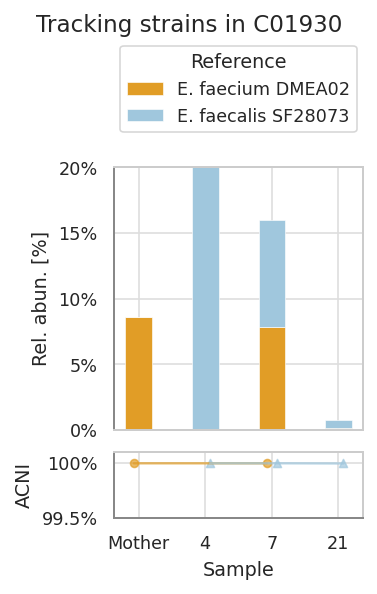

In [134]:
from collections import defaultdict
from matplotlib import ticker

seaborn.set_context("paper")


def acni_over_time_plot(axes, straingst_results, compare_results, 
                        samples, sample_labels=None, strains=None, 
                        strain_shapes=None, color_map=None):
    colors = seaborn.color_palette("tab10")
    bottom = numpy.zeros(len(samples), dtype=float)
    x = numpy.arange(len(samples))
    
    straingst_refs = list(straingst_results.index.unique(level=1))
    color_map = color_map if color_map else dict(zip(straingst_refs, colors))
    for ref in straingst_refs:
        nice_name = nice_ref_name(ref)
        color = color_map[nice_name]
            
        ra = numpy.array([straingst_results.loc[(sample, ref), 'rapct'] if (sample, ref) in straingst_results.index else 0.0 for sample in samples], dtype=float)
        axes[0].bar(x, ra, bottom=bottom, color=color, align='center', label=nice_name, width=0.4, lw=0.3)

        bottom += ra
        
    axes[0].set_ylabel("Rel. abun. [%]")
    axes[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}%"))
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(samples)
    
    # ACNI compared to prev sample
    axes[1].set_ylim(99.5, 100.1)
    axes[1].set_xlabel("Sample")
    axes[1].set_ylabel("ACNI")
    axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}%"))
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(samples)
    
    strain_shapes = strain_shapes if strain_shapes else ['o'] * len(strains)
    jitter = numpy.linspace(0, 0.15, len(strains))
    jitter -= (jitter[-1] - jitter[0]) / 2  # center on 0
    for ref, shape, jitter_x in zip(strains, strain_shapes, jitter):
        nice_name = nice_ref_name(ref)
        color = color_map[nice_name]
            
        curr_x = []
        curr_y = []
        prev_with_strain = None
        for sample_x, sample in zip(x, samples):
            if prev_with_strain is not None:
                ix = (prev_with_strain, sample, ref)
                ix2 = (sample, prev_with_strain, ref)
                print(ix, ix2)
                if ix in compare_results.index:
                    curr_x.append(sample_x)
                    curr_y.append(compare_results.loc[ix, 'singleAgreePct'])
                elif ix2 in compare_results.index:
                    curr_x.append(sample_x)
                    curr_y.append(compare_results.loc[ix2, 'singleAgreePct'])

            if (sample, ref) in straingst_results.index:
                prev_with_strain = sample
                
                if not curr_x:
                    curr_x = [sample_x]
                    curr_y = [100]
                
        if len(curr_x) > 1:
            curr_x = numpy.array(curr_x)
            curr_y = numpy.array(curr_y)
            
            #jitter_y = jitter_x / 8
            jitter_y = 0
            axes[1].plot(curr_x + jitter_x, curr_y+jitter_y, color=color, label=nice_name, alpha=0.7)
            axes[1].scatter(curr_x + jitter_x, curr_y+jitter_y, color=color, s=16, marker=shape, alpha=0.7)
            
    return axes

samples_per_subject = defaultdict(list)
sample_meta = run_meta.reset_index().set_index(['Individual', 'Time_point']).sort_index().reset_index(level=1)

for individual in sample_meta.index.unique():
    samples_per_subject[individual] = [s for s in sample_meta.loc[individual, 'Time_point'] if s != "Infancy"]
    
strain_order = ['Ente_faecium_DMEA02', 'Ente_faecalis_SF28073']
strain_shapes = ['o', '^']
    
fig, axes = plt.subplots(2, 1, figsize=(2.5, 4), sharex='col', constrained_layout=True, gridspec_kw={"height_ratios": [4, 1]})

acni_over_time_plot(axes, without_infancy_df.loc['C01930'], same_subject_compare.loc["C01930", "C01930"],
                    samples_per_subject["C01930"], strains=strain_order, strain_shapes=strain_shapes, color_map=strain_color_map)

l = axes[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.1), title="Reference")

axes[0].set_ylim(0, 20)
spine_color = "#888888"
axes[0].spines["left"].set_color(spine_color)
axes[1].spines["left"].set_color(spine_color)
axes[1].spines["bottom"].set_color(spine_color)

fig.suptitle("Tracking strains in C01930")
fig.savefig('paper_fig/entero_c01930_acni.svg', bbox_inches='tight')
plt.show()


In [137]:
compare_complete_df_pass_qc.loc[('C01930', 'C01930'), :]

/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


,,,sample1,sample2,scaffold,length,common,commonPct,single,singlePct,singleAgree,singleAgreePct,...,same_subject,straingst_present,enough_cov,nice_name,hospital1,hospital2,same_hospital,species,st,isolate_ani
tp1,tp2,ref,,,,,,,,,,,,,,,,,,,,,
7,Mother,Ente_faecium_DMEA02,ERR3405439,ERR3405440,NZ_CP043484.1,2573925,2420738,94.0485,2420416,99.9867,2420408,99.9997,...,True,True,True,E. faecium DMEA02,C,C,True,faecium,178.0,NaN
21,7,Ente_faecalis_SF28073,ERR3405437,ERR3405439,NZ_CP060804.1,3039501,1665821,54.8057,1665588,99.9860,1665560,99.9983,...,True,True,True,E. faecalis SF28073,C,C,True,faecalis,2.0,NaN
4,7,Ente_faecalis_SF28073,ERR3405438,ERR3405439,NZ_CP060804.1,3039501,2655898,87.3794,2655533,99.9863,2655533,100.0000,...,True,True,True,E. faecalis SF28073,C,C,True,faecalis,2.0,NaN
21,4,Ente_faecalis_SF28073,ERR3405437,ERR3405438,NZ_CP060804.1,3039501,1665020,54.7794,1664916,99.9938,1664892,99.9986,...,True,True,True,E. faecalis SF28073,C,C,True,faecalis,2.0,NaN


In [154]:
interested_compare_df = compare_complete_df_pass_qc.loc[(slice(None), slice(None), slice(None), slice(None), selected_refs), :].copy()
interested_compare_df['involves_c01930'] = interested_compare_df.index.map(lambda ix: ix[0] == "C01930" or ix[1] == "C01930")
interested_compare_df = interested_compare_df[interested_compare_df['involves_c01930']]

selected_refs_nice = list(map(nice_ref_name, selected_refs))
interested_color_scale =alt.Scale(domain=selected_refs_nice, range=[strain_color_map[s] for s in selected_refs_nice])

c = alt.Chart(interested_compare_df.reset_index()).mark_circle(opacity=0.6, stroke="black").encode(
    alt.X('gapJaccardSim', scale=alt.Scale(zero=False, domain=[0.91, 1.0]), title="Gap Similarity"),
    alt.Y('singleAgreePct', scale=alt.Scale(zero=False, domain=[99.2, 100]), title="Pairwise ACNI [%]"),
    size=alt.Size('commonPct', type="quantitative", title="Common Callable [%]",
                  scale=alt.Scale(range=(25, 500))),
    color=alt.Color('nice_name:N', scale=interested_color_scale, title="Reference"),
    strokeWidth=alt.StrokeWidth('same_subject:O', title="Same subject", scale=alt.Scale(domain=[False, True], range=[0, 1.5])),
    tooltip=['subject1', 'subject2', 'tp1', 'tp2', 'ref', 'commonPct', 'singleAgreePct', 'gapJaccardSim', 'sharedAllelesPct']
)
c.properties(width=300, height=300)

alt.Chart(...)

In [136]:
interested_compare_df

,,,,,sample1,sample2,scaffold,length,common,commonPct,single,singlePct,singleAgree,singleAgreePct,...,straingst_present,enough_cov,nice_name,hospital1,hospital2,same_hospital,species,st,isolate_ani,involves_c01930
subject1,subject2,tp1,tp2,ref,,,,,,,,,,,,,,,,,,,,,
B02109,C01930,4,Mother,Ente_faecium_DMEA02,ERR3405504,ERR3405440,NZ_CP043484.1,2573925,2405246,93.4466,2404866,99.9842,2402928,99.9194,...,True,True,E. faecium DMEA02,B,C,False,faecium,178.0,NaN,True
A01966,C01930,7,Mother,Ente_faecium_DMEA02,ERR3405451,ERR3405440,NZ_CP043484.1,2573925,2147466,83.4316,2147278,99.9912,2137135,99.5276,...,True,True,E. faecium DMEA02,A,C,False,faecium,178.0,NaN,True
B00922,C01930,7,7,Ente_faecium_DMEA02,ERR3404978,ERR3405439,NZ_CP043484.1,2573925,2391334,92.9061,2386252,99.7875,2376914,99.6087,...,True,True,E. faecium DMEA02,B,C,False,faecium,178.0,NaN,True
C01930,C02061,Mother,Infancy,Ente_faecium_DMEA02,ERR3405440,ERR3406038,NZ_CP043484.1,2573925,319791,12.4243,319760,99.9903,319684,99.9762,...,True,True,E. faecium DMEA02,C,C,True,faecium,178.0,NaN,True
B02109,C01930,4,7,Ente_faecium_DMEA02,ERR3405504,ERR3405439,NZ_CP043484.1,2573925,2406591,93.4989,2406158,99.9820,2404205,99.9188,...,True,True,E. faecium DMEA02,B,C,False,faecium,178.0,NaN,True
A01671,C01930,21,7,Ente_faecium_DMEA02,ERR3405345,ERR3405439,NZ_CP043484.1,2573925,1610633,62.5750,1610499,99.9917,1609552,99.9412,...,True,True,E. faecium DMEA02,A,C,False,faecium,178.0,NaN,True
B01716,C01930,Infancy,Mother,Ente_faecium_DMEA02,ERR3406014,ERR3405440,NZ_CP043484.1,2573925,541869,21.0522,541808,99.9887,540397,99.7396,...,True,True,E. faecium DMEA02,B,C,False,faecium,178.0,NaN,True
B02511,C01930,Infancy,Mother,Ente_faecium_DMEA02,ERR3406210,ERR3405440,NZ_CP043484.1,2573925,249694,9.7009,249666,99.9888,248223,99.4220,...,True,True,E. faecium DMEA02,B,C,False,faecium,178.0,NaN,True
C01930,C02061,7,Infancy,Ente_faecium_DMEA02,ERR3405439,ERR3406038,NZ_CP043484.1,2573925,320061,12.4347,320032,99.9909,319934,99.9694,...,True,True,E. faecium DMEA02,C,C,True,faecium,178.0,NaN,True
